# SD XL

In [1]:
# import scripts.control_utils as cu
from importlib import reload
import matplotlib.pyplot as plt
from annotator.midas import MidasDetector
from annotator.canny import CannyDetector
from ldm.data.util import resize_image_pil
import torch
import torchvision.transforms as tt
import numpy as np

from PIL import Image
# reload(cu)
from safetensors.torch import save_file
import glob 

torch.cuda.set_device('cuda:0')
import tqdm


In [8]:
import scripts.control_utils as cu
import os

def load_model_from_dic (path_dic, Lora_kitti, Lora_cubes):

    model = cu.create_model(path_dic['yaml'])

    if path_dic['ckpt'] != None: 
        ckpt = torch.load(path_dic['ckpt'], map_location='cpu')
        model.load_state_dict(ckpt['state_dict'], strict=False)
    

    if Lora_kitti: 
        LORA_ckpt = torch.load('/export/data/vislearn/rother_subgroup/feiden/models/pretrained/stable_diffusion_XL/sdxl_kitti.safetensors',
                                map_location='cpu')
        model.load_state_dict(LORA_ckpt['state_dict'], strict=False)
    if Lora_cubes: 
        LORA_ckpt = torch.load('/export/data/vislearn/rother_subgroup/sdxl_render.safetensors', map_location='cpu')
        model.load_state_dict(LORA_ckpt['state_dict'], strict=False)
    
    return model.to('cuda')

def get_paths (root, yaml_path, ckpt_path):
    path_dic = {}
    if type(yaml_path) is str:
        path_dic['yaml'] = os.path.join(root, yaml_path)
    else: 
        path_dic['ymal'] = None

    if type(ckpt_path) is str:
        path_dic['ckpt'] = os.path.join(root, ckpt_path)
    else: 
        path_dic['ckpt'] = None
    return path_dic

model_paths = {}

model_paths['CNXS_10'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sdxl/midas/2023-08-16T12-53-33_cross_encD_cat_learnEmb_10p_depth/',
                                   yaml_path='configs/project.yaml',
                                   ckpt_path= None)

model_paths['CNXS_Kitti'] = get_paths(root='/export/home/ffeiden/Projects/ControlNet-XS/configs/inference/sdxl/',
                                   yaml_path='sdxl_encD_depth_48m.yaml',
                                   ckpt_path= None)

model_paths['CNXS_50'] = get_paths(root='/export/home/ffeiden/Projects/ControlNet-XS/',
                                   yaml_path='configs/inference/sdxl/sdxl_50p_project.yaml',
                                   ckpt_path= None)

# model_paths['CNXS_20'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sdxl/midas/2023-08-22T14-31-49_cross_encD_cat_20p_lr4_learnEmb_depth/',
#                                    yaml_path='configs/2023-08-22T14-31-49-project.yaml',
#                                    ckpt_path= 'checkpoints/epoch=000000-step=000012000.ckpt')



In [3]:
image_root = '/export/data/ffeiden/PaperControlnetXS/512_images/'
size = 512
reload(glob)

paths = glob.glob(image_root+'*_depth*.png')

instances = []
for im_path in paths: 
    images = {}
    name = im_path.split('/')[-1]
    name, alternative = name.split('_depth')[0], name.split('_depth')[1]
    if '_alt' in alternative: 
        alternative = True
    else: 
        alternative = False
    
    image = cu.get_image(image_root + name + '.png')
    depth = Image.open(im_path)
    if not depth.mode == 'L':
        depth = depth.convert("L") 
    images['original'] = image
    images['depth'] = np.array(depth).astype(np.float32)/255.
    images['Prompt'] = name
    images['alt'] = alternative
    if 'badPrompts' in image_root:
        if 'cube on' in name: 
            images['insuf_Prompt'] = 'render of a lavender sphere floating in the air'
            images['conflicting_Prompt'] = 'image of a house surrounded by an beautiful garden'
        else: 
            images['insuf_Prompt'] = 'high quality, 4k, detailed, professional work'
            images['conflicting_Prompt'] = 'high quality photo of a delecious cake'
    # print(np.min(images['depth']), np.max(images['depth']), images['depth'].shape)
    instances.append(images)

In [9]:
current = instances[6]
model = load_model_from_dic(model_paths['CNXS_Kitti'], False, False)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.layer_norm1.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.20.self_attn.q_proj.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.la

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Loaded model config from [/export/home/ffeiden/Projects/ControlNet-XS/configs/inference/sdxl/sdxl_encD_depth_48m.yaml]


Global seed set to 2024


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.0]


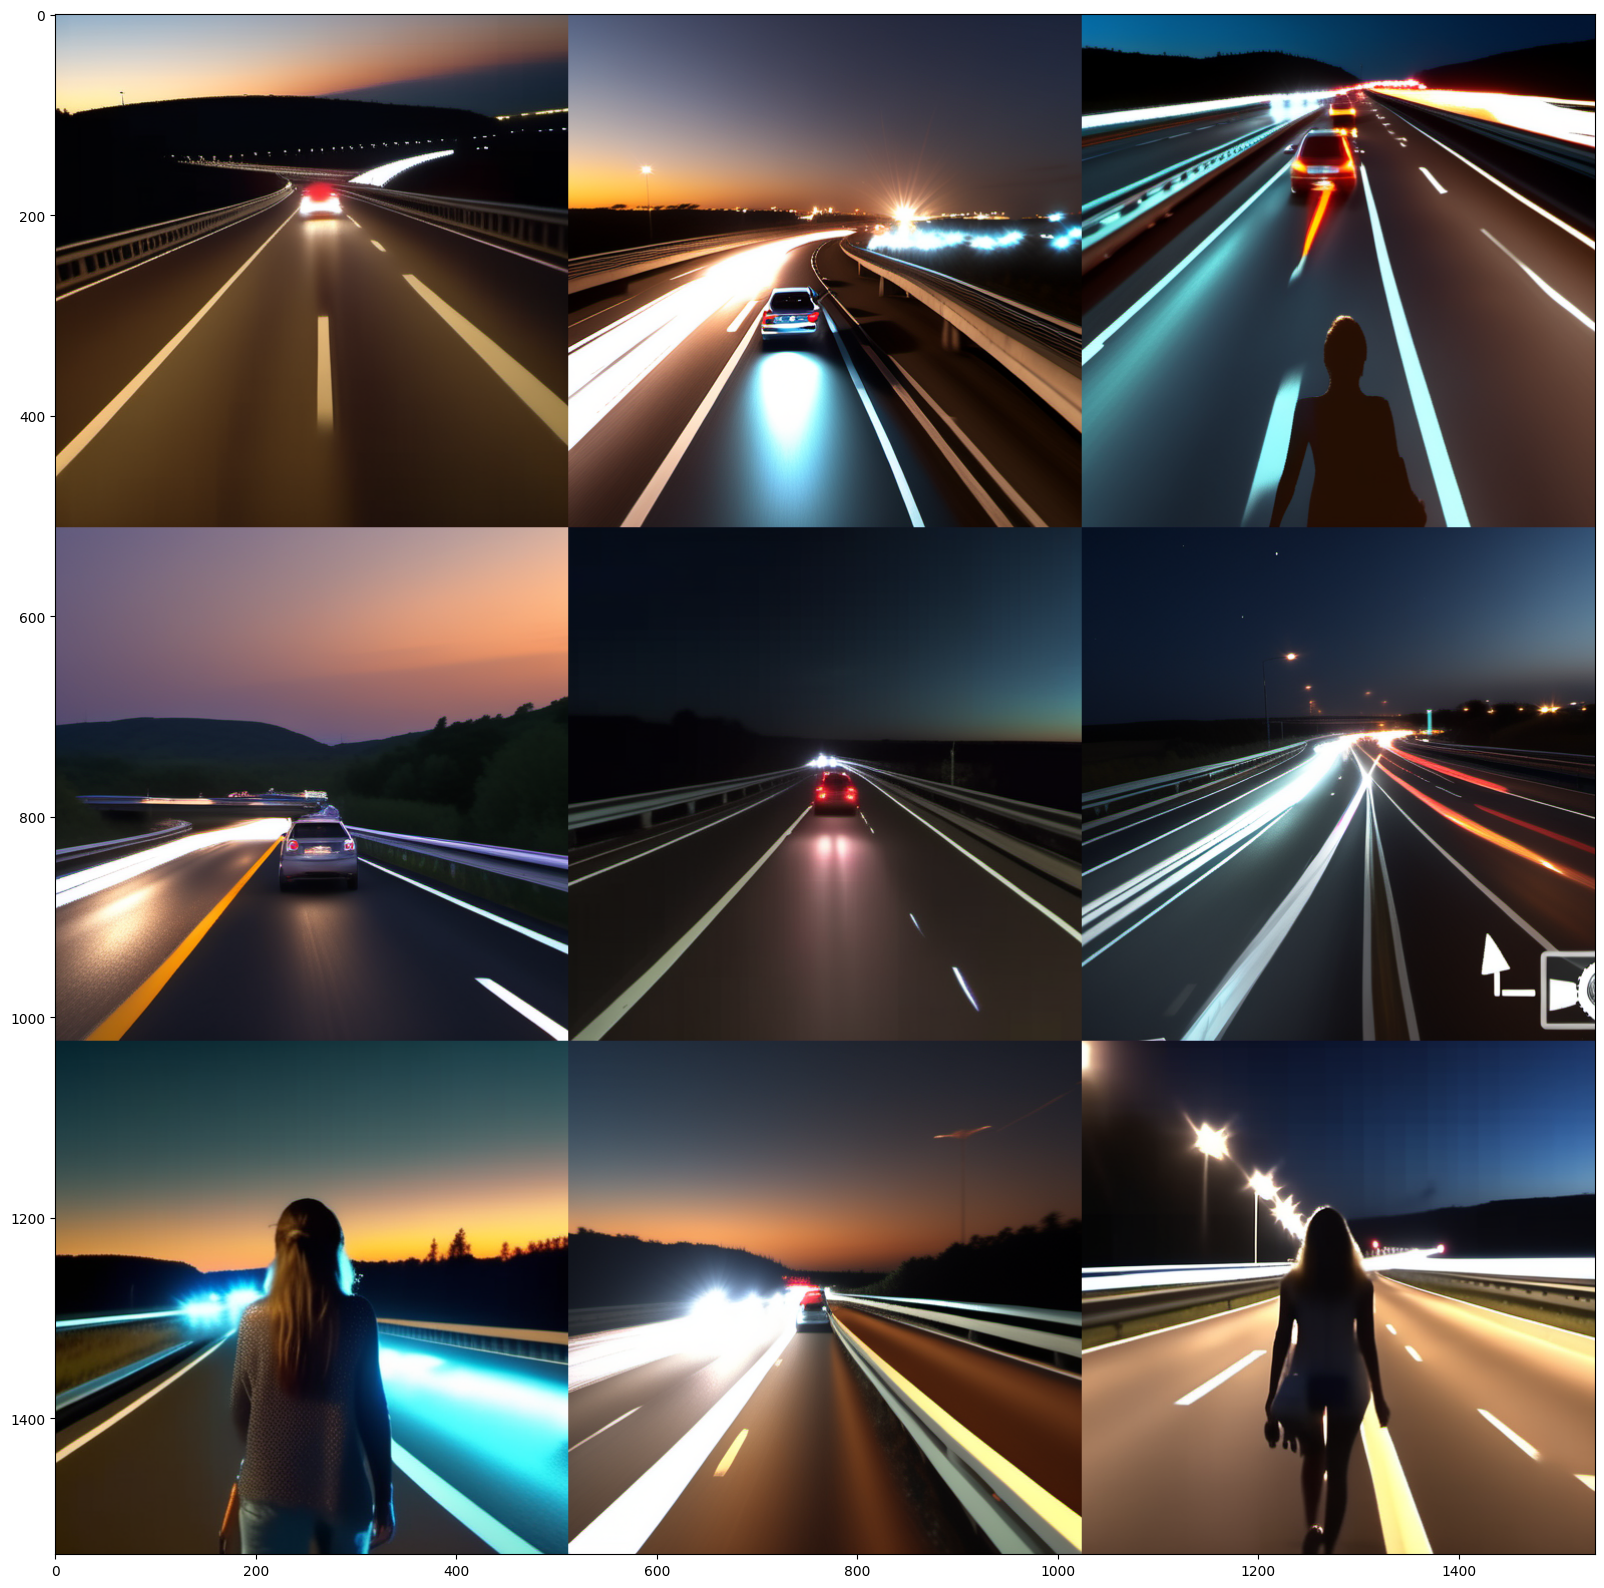

In [14]:
size = 512
samples, controls = cu.get_sdxl_sample(
                    guidance=current['depth'],
                    ddim_steps=50,
                    num_samples=9,
                    model=model,
                    seed=2024,
                    shape=[4, size // 8, size // 8],
                    control_scale=0.,
                    prompt='Dashcam image of a woman crossing a highway. Highly detailed, 4k image, sharp image, professional photograph, rual, dashcam, night time',
                    n_prompt='empty street',
                )

plt.figure(figsize=(20, 20))
plt.imshow(cu.create_image_grid(samples))
plt.show()

In [13]:
to_save = Image.fromarray(cu.create_image_grid(samples))
to_save.save('Grid_XL_seed2024_nPrompt_empty street.png')

In [4]:
### Automate sampling ###
def sample (model, net, subfolder, root):
    
    os.mkdir(root+ net + subfolder)
    os.mkdir(root + net + subfolder + 'AA_grids')
    
    for current in instances:
        for prompt_key in ['Prompt',]: #  'insuf_Prompt', 'conflicting_Prompt'
            for seed in [1995, 1996, 1998, 2024]:

                if current['alt']:
                    sampe_name = current['Prompt'] + '_' + prompt_key + '_alt'
                else: 
                    sampe_name = current['Prompt']+ '_' + prompt_key

                samples, controls = cu.get_sdxl_sample(
                    guidance=current['depth'],
                    ddim_steps=50,
                    num_samples=9,
                    model=model,
                    seed=seed,
                    shape=[4, size // 8, size // 8],
                    control_scale=1.,
                    prompt=current[prompt_key],
                    n_prompt='',
                )
                
                to_save = Image.fromarray(cu.create_image_grid(samples))
                to_save.save(root+net+subfolder+'AA_grids/'+sampe_name+'_seed'+str(seed)+'.png')

                # Generate score 
                best_depth_score = 999.999
                best_gen = None
                best_org_depth = None
                best_gen_depth = None

                for i in range(samples.shape[0]):
                    
                    to_save = Image.fromarray(samples[i])
                    to_save.save(root+net+subfolder+sampe_name+'_seed'+str(seed)+'_samp'+str(i)+'.png')


In [8]:
root = '/export/data/ffeiden/ResultsControlNetXS/'
net = 'CNXS_SDXL/'

for name_net in model_paths: 
    
    model = load_model_from_dic(model_paths[name_net], False, False)
    subfolder = name_net + '/'
    sample(model, net, subfolder, root)

    # model = load_model_from_dic(model_paths[name_net], True, False)
    # subfolder = name_net + '_kitti/'
    # sample(model, net, subfolder, root)

    # model = load_model_from_dic(model_paths[name_net], False, True)
    # subfolder = name_net + '_cubes/'
    # sample(model, net, subfolder, root)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.12.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.embeddings.position_embedding.weight', 'vision_model.encoder.layers.22.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.20.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layer

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Loaded model config from [/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sdxl/midas/2023-08-16T12-53-33_cross_encD_cat_learnEmb_10p_depth/configs/project.yaml]


Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set to 1996
Global seed set to 1998
Global seed set to 2024
Global seed set to 1995
Global seed set 

In [20]:
model = load_model_from_dic(model_paths['CNXS_50'], False, False)


Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.14.mlp.fc2.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.en

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Loaded model config from [/export/home/ffeiden/Projects/ControlNet-XS/configs/inference/sdxl/sdxl_50p_project.yaml]


In [21]:
current = instances[6]

samples, controls = cu.get_sdxl_sample(
                    guidance=current['depth'],
                    ddim_steps=25,
                    num_samples=9,
                    model=model,
                    seed=1995,
                    shape=[4, size // 8, size // 8],
                    control_scale=1.,
                    prompt=current['Prompt'],
                    n_prompt='',
                )

plt.figure(figsize=(20, 20))
plt.imshow(cu.create_image_grid(samples))
plt.show()

Global seed set to 1995


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 39.42 GiB total capacity; 36.39 GiB already allocated; 395.06 MiB free; 38.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

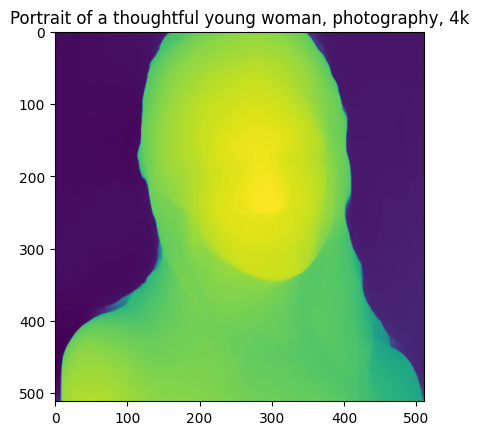

In [15]:
plt.imshow(current['depth'])
plt.title(current['Prompt'])
plt.show()